In [4]:
import os
import numpy as np
import netCDF4 as nc
from datetime import timedelta, datetime
from scipy.io import loadmat
from parcels import Field, FieldSet, ParticleSet, JITParticle, AdvectionRK4, AdvectionRK4DiffusionM1, plotTrajectoriesFile, ErrorCode
import matplotlib.pyplot as plt
%matplotlib inline

# Need parcels own random function for kernels
from parcels import rng as random
import math

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Combining separate files to create one dataset

# data directory
datadir = 'HYCOMdata_Sep15_Noc16/'

# List local file names
matfnames=[]
for root, dirs, files in os.walk(datadir):
    for filename in files:
        matfnames.append(filename)

# data structures within the .mat file
DD_lst = ['D0','D3', 'D6', 'D9', 'D12', 'D15', 'D18', 'D21']

# import matlab data
data = loadmat(datadir+matfnames[0])
# pre-allocate
ttlen = len(DD_lst)*len(matfnames)
ltlen = len(data[DD_lst[0]][0][0][1])
lnlen = len(data[DD_lst[0]][0][0][2])
U = np.empty((ttlen,ltlen,lnlen))
V = np.empty((ttlen,ltlen,lnlen))
SE = np.empty((ttlen,ltlen,lnlen))
tt = np.empty((ttlen), dtype='datetime64[s]')

# loop through daily .mat files
cc=0
for matfname in matfnames:
    # import matlab data
    data = loadmat(datadir+matfname)
    # unpack data
    for ii,DD in enumerate(DD_lst):
        t = float(data[DD][0][0][6][0][0]) # time
        # Convert MATLAB datenum to python datetime
        python_datetime = datetime.fromordinal(int(t)) + timedelta(days=t%1) - timedelta(days = 366)
        tt[cc] = python_datetime
        U[cc,:,:] = data[DD][0][0][0][:,:,0] # (626, 876) u
        V[cc,:,:] = data[DD][0][0][1][:,:,0] # (626, 876) v
        SE[cc,:,:] = data[DD][0][0][5] # (626, 876) surface elevation
        cc+=1

d = data[DD][0][0][4] # depth
# ln = data[DD][0][0][2]
# lt = data[DD][0][0][1]
 
ln = data['ln2'] # (626, 876) longitude     
lt = data['lt2'] # (626, 876) latitude 

In [6]:
# Initialise FieldSet object from raw data
data       = {'U': U,
              'V': V}
variables  = {'U': 'U',
              'V': 'V'}
dimensions = {'time': tt,
              'lon': ln,
              'lat': lt}

fieldset = FieldSet.from_data(data, dimensions, transpose=False, mesh='spherical', 
                              allow_time_extrapolation=True, time_periodic=False)

In [ ]:
# release particles in a straight line
pset = ParticleSet.from_line(fieldset=fieldset, size=100, pclass=JITParticle,
                             start=(-82, 24), finish=(-78, 24), time=tt[0])
# original position
pset.show(field='vector', vmax=5.0, domain={'N':40, 'S':10, 'E':-65, 'W':-88}, land=True)

In [60]:
# release particles in a cluster to find optimal intial drop point
slon = np.arange(-97,-55,1)
slat = np.arange(10,35,1)
lons, lats = np.meshgrid(slon,slat)
start_time = tt[0]
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=start_time)

Want to identify hurricane based on magnitude of vectors

In [7]:
from datetime import datetime
from datetime import timedelta as delta

import numpy as np

from parcels.field import Field
from parcels.field import VectorField
from parcels.grid import CurvilinearGrid
from parcels.grid import GridCode

In [8]:
def create_parcelsfig_axis(spherical, land=True, projection=None, central_longitude=0):
    try:
        import matplotlib.pyplot as plt
    except:
        logger.info("Visualisation is not possible. Matplotlib not found.")
        return None, None, None, None  # creating axes was not possible

    if projection is not None and not spherical:
        raise RuntimeError('projection not accepted when Field doesn''t have geographic coordinates')

    if spherical:
        try:
            import cartopy
        except:
            logger.info("Visualisation of field with geographic coordinates is not possible. Cartopy not found.")
            return None, None, None, None  # creating axes was not possible

        projection = cartopy.crs.PlateCarree(central_longitude) if projection is None else projection
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})
        try:  # gridlines not supported for all projections
            gl = ax.gridlines(crs=projection, draw_labels=True)
            gl.xlabels_top, gl.ylabels_right = (False, False)
            gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
            gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
        except:
            pass

        if land:
            ax.coastlines()
    else:
        cartopy = None
        fig, ax = plt.subplots(1, 1)
        ax.grid()
    return plt, fig, ax, cartopy

In [9]:
def parsedomain(domain, field):
    field.grid.check_zonal_periodic()
    if domain is not None:
        if not isinstance(domain, dict) and len(domain) == 4:  # for backward compatibility with <v2.0.0
            domain = {'N': domain[0], 'S': domain[1], 'E': domain[2], 'W': domain[3]}
        _, _, _, lonW, latS, _ = field.search_indices(domain['W'], domain['S'], 0, 0, 0, search2D=True)
        _, _, _, lonE, latN, _ = field.search_indices(domain['E'], domain['N'], 0, 0, 0, search2D=True)
        return latN+1, latS, lonE+1, lonW
    else:
        if field.grid.gtype in [GridCode.RectilinearSGrid, GridCode.CurvilinearSGrid]:
            return field.grid.lon.shape[0], 0, field.grid.lon.shape[1], 0
        else:
            return len(field.grid.lat), 0, len(field.grid.lon), 0

In [10]:
def cartopy_colorbar(cs, plt, fig, ax):
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    plt.colorbar(cs, cax=cbar_ax)

    def resize_colorbar(event):
        plt.draw()
        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0, 0.04, posn.height])

    fig.canvas.mpl_connect('resize_event', resize_colorbar)
    resize_colorbar(None)

In [11]:
def parsetimestr(time_origin, show_time):
    if time_origin.calendar is None:
        return ' after ' + str(delta(seconds=show_time)) + ' hours'
    else:
        date_str = str(time_origin.fulltime(show_time))
        return ' on ' + date_str[:10] + ' ' + date_str[11:19]

In [57]:
# deletes particle when out of bounds
def DeleteParticle(particle, fieldset, time):
    particle.delete() 

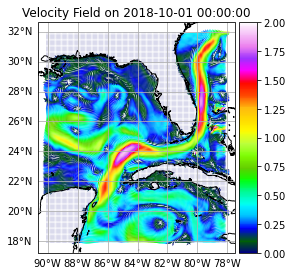

In [121]:
domain={'N':32, 'S':18, 'E':-78, 'W':-90} # manually change
show_time = tt[128] # subject to change

field = pset.fieldset.UV
type(field)
vmax = 2.0
vmin = 0.0
spherical = True if field.U.grid.mesh == 'spherical' else False
field = [field.U, field.V]
plottype = 'vector'
land = True
plt, fig, ax, cartopy = create_parcelsfig_axis(spherical, land, projection=None)

if isinstance(show_time, np.datetime64):
    show_time = pset.time_origin.reltime(show_time)

# set up domain
data = {}
plotlon = {}
plotlat = {}
for i, fld in enumerate(field):

    (idx, periods) = fld.time_index(show_time)
    show_time -= periods * (fld.grid.time_full[-1] - fld.grid.time_full[0])
    if show_time > fld.grid.time[-1] or show_time < fld.grid.time[0]:
        raise TimeExtrapolationError(show_time, field=fld, msg='show_time')

    latN, latS, lonE, lonW = parsedomain(domain, fld)
    if isinstance(fld.grid, CurvilinearGrid):
        plotlon[i] = fld.grid.lon[latS:latN, lonW:lonE]
        plotlat[i] = fld.grid.lat[latS:latN, lonW:lonE]
    else:
        plotlon[i] = fld.grid.lon[lonW:lonE]
        plotlat[i] = fld.grid.lat[latS:latN]
    if i > 0 and not np.allclose(plotlon[i], plotlon[0]):
        raise RuntimeError('VectorField needs to be on an A-grid for plotting')
    if fld.grid.time.size > 1:
        data[i] = np.squeeze(fld.temporal_interpolate_fullfield(idx, show_time))[latS:latN, lonW:lonE]
    else:
        data[i] = np.squeeze(fld.data)[latS:latN, lonW:lonE]
            
            
if plottype == 'vector':
    spd = data[0] ** 2 + data[1] ** 2
    speed = np.where(spd > 0, np.sqrt(spd), 0)
    vmin = np.min(speed) if vmin is None else vmin
    vmax = np.max(speed) if vmax is None else vmax
    x, y = plotlon[0], plotlat[0]
    u = np.where(speed > 0., data[0]/speed, 0)
    v = np.where(speed > 0., data[1]/speed, 0)
    cs = ax.quiver(np.asarray(x), np.asarray(y), np.asarray(u), np.asarray(v), speed, 
                   cmap=plt.cm.gist_ncar, clim=[vmin, vmax], scale=50, transform=cartopy.crs.PlateCarree())
   
cs.cmap.set_over('k')
cs.cmap.set_under('w')
cs.set_clim(vmin, vmax)

cartopy_colorbar(cs, plt, fig, ax)
timestr = parsetimestr(field[0].grid.time_origin, show_time)
ax.set_title('Velocity Field' + timestr)

plt.draw()
plt.show()

In [114]:
# want to create mapping of high magnitudes
u = np.where(speed > .50, data[0]/speed, 0)
v = np.where(speed > .50, data[1]/speed, 0)

In [ ]:
# animation zoomed in, focusing on hurricane hit florida
slon = np.arange(-90,-75,1)
slat = np.arange(18,32,1)
lons, lats = np.meshgrid(slon,slat)
start_time = tt[160]
end_time = tt[248]
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=start_time)

for cnt in range(100): # endtime
    # First plot the particles
    pset.show(savefile='hwparticles'+str(cnt).zfill(2), field='vector', land=True, vmax=2.0, 
               domain={'N':32, 'S':18, 'E':-75, 'W':-90}, with_particles = True)
    # Then advect the particles
    pset.execute(AdvectionRK4,
                 runtime=timedelta(hours=3),  # runtime controls the interval of the plots
                 dt=timedelta(minutes=5),
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})  # the recovery kernel

# then stich together saved images in Gif Movie Gear

In [ ]:
slon = np.arange(-90,-75,1)
slat = np.arange(18,32,1)
lons, lats = np.meshgrid(slon,slat)
start_time = tt[160]
end_time = tt[248]
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=start_time)

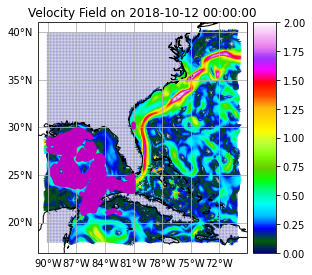

In [324]:
domain={'N':40, 'S':18, 'E':-70, 'W':-90} # manually change
show_time = tt[200] # subject to change

field = pset.fieldset.UV
type(field)
vmax = 2.0
vmin = 0.0
spherical = True if field.U.grid.mesh == 'spherical' else False
field = [field.U, field.V]
plottype = 'vector'
land = True
plt, fig, ax, cartopy = create_parcelsfig_axis(spherical, land, projection=None)

if isinstance(show_time, np.datetime64):
    show_time = pset.time_origin.reltime(show_time)

# set up domain
data = {}
plotlon = {}
plotlat = {}
for i, fld in enumerate(field):

    (idx, periods) = fld.time_index(show_time)
    show_time -= periods * (fld.grid.time_full[-1] - fld.grid.time_full[0])
    if show_time > fld.grid.time[-1] or show_time < fld.grid.time[0]:
        raise TimeExtrapolationError(show_time, field=fld, msg='show_time')

    latN, latS, lonE, lonW = parsedomain(domain, fld)
    if isinstance(fld.grid, CurvilinearGrid):
        plotlon[i] = fld.grid.lon[latS:latN, lonW:lonE]
        plotlat[i] = fld.grid.lat[latS:latN, lonW:lonE]
    else:
        plotlon[i] = fld.grid.lon[lonW:lonE]
        plotlat[i] = fld.grid.lat[latS:latN]
    if i > 0 and not np.allclose(plotlon[i], plotlon[0]):
        raise RuntimeError('VectorField needs to be on an A-grid for plotting')
    if fld.grid.time.size > 1:
        data[i] = np.squeeze(fld.temporal_interpolate_fullfield(idx, show_time))[latS:latN, lonW:lonE]
    else:
        data[i] = np.squeeze(fld.data)[latS:latN, lonW:lonE]
            
            
spd = data[0] ** 2 + data[1] ** 2
speed = np.where(spd > 0, np.sqrt(spd), 0)
vmin = np.min(speed) if vmin is None else vmin
vmax = np.max(speed) if vmax is None else vmax
x, y = plotlon[0], plotlat[0]
u = np.where(speed > 0., data[0]/speed, 0)
v = np.where(speed > 0., data[1]/speed, 0)

cs = ax.quiver(np.asarray(x), np.asarray(y), np.asarray(u), np.asarray(v), speed, 
               cmap=plt.cm.gist_ncar, clim=[vmin, vmax], scale=50, transform=cartopy.crs.PlateCarree())

nu = np.where(speed > v_cutoff, data[0]/speed, 0)
nv = np.where(speed > v_cutoff, data[1]/speed, 0)

nx = []
ny = []
(n,m) = speed.shape
for ii in range(0,n):
    for jj in range(0,m):
        if speed[ii,jj] > .50:
        #if nu[ii,jj] != 0: 
            nx = x[ii,jj]
            ny = y[ii,jj]
            if nx < -81 and nx > -90 and ny > 21:
                plt.plot(nx,ny, '.', color='m')            

cs.cmap.set_over('k')
cs.cmap.set_under('w')
cs.set_clim(vmin, vmax)

cartopy_colorbar(cs, plt, fig, ax)
timestr = parsetimestr(field[0].grid.time_origin, show_time)
ax.set_title('Velocity Field' + timestr)

plt.draw()
plt.show()

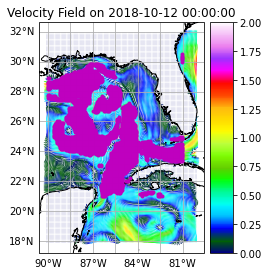

In [334]:
show_time=tt[200]
velocity_magnitude(cnt,field, show_time, domain, v_cutoff)

In [53]:
def velocity_magnitude(rd, cnt, field, show_time, domain, v_cutoff):

    field = [field.U, field.V]
    plt, fig, ax, cartopy = create_parcelsfig_axis(spherical=True, land=True, projection=None)
    if isinstance(show_time, np.datetime64):
        show_time = pset.time_origin.reltime(show_time)

    # set up domain
    data = {}
    plotlon = {}
    plotlat = {}
    for i, fld in enumerate(field):

        (idx, periods) = fld.time_index(show_time)
        show_time -= periods * (fld.grid.time_full[-1] - fld.grid.time_full[0])

        latN, latS, lonE, lonW = parsedomain(domain, fld)
        if isinstance(fld.grid, CurvilinearGrid):
            plotlon[i] = fld.grid.lon[latS:latN, lonW:lonE]
            plotlat[i] = fld.grid.lat[latS:latN, lonW:lonE]
        else:
            plotlon[i] = fld.grid.lon[lonW:lonE]
            plotlat[i] = fld.grid.lat[latS:latN]
        if i > 0 and not np.allclose(plotlon[i], plotlon[0]):
            raise RuntimeError('VectorField needs to be on an A-grid for plotting')
        if fld.grid.time.size > 1:
            data[i] = np.squeeze(fld.temporal_interpolate_fullfield(idx, show_time))[latS:latN, lonW:lonE]
        else:
            data[i] = np.squeeze(fld.data)[latS:latN, lonW:lonE]
            
      
    spd = data[0] ** 2 + data[1] ** 2
    speed = np.where(spd > 0, np.sqrt(spd), 0)
    vmax = 2.0
    vmin = 0.0  
    x, y = plotlon[0], plotlat[0]
    u = np.where(speed > 0., data[0]/speed, 0)
    v = np.where(speed > 0., data[1]/speed, 0)
    cs = ax.quiver(np.asarray(x), np.asarray(y), np.asarray(u), np.asarray(v), speed, 
                   cmap=plt.cm.gist_ncar, clim=[vmin, vmax], scale=50, transform=cartopy.crs.PlateCarree())
    
    nu = np.where(speed > v_cutoff, data[0]/speed, 0)
    nv = np.where(speed > v_cutoff, data[1]/speed, 0)
    nx = []
    ny = []
    (n,m) = speed.shape
    if rd > 0:
        for ii in range(0,n):
            for jj in range(0,m):
                if speed[ii,jj] > .6 and speed[ii,jj] < 1.3:
                    nx = x[ii,jj]
                    ny = y[ii,jj]
                    if rd == 1:    
                        if nx < -78 and nx > -82 and ny > 27 and ny < 35:
                            plt.plot(nx,ny, '.', color='m')  
                    if rd == 2:
                         if nx < -74 and nx > -82 and ny > 31 and ny < 35:
                            plt.plot(nx,ny, '.', color='m')  
                    if rd == 3:
                         if nx < -70 and nx > -82 and ny > 34 and ny < 40:
                            plt.plot(nx,ny, '.', color='m')  
    else:        
        for ii in range(0,n):
            for jj in range(0,m):
                if speed[ii,jj] > .50:
                    nx = x[ii,jj]
                    ny = y[ii,jj]
                    if nx < -81 and nx > -90 and ny > 22.5:
                        plt.plot(nx,ny, '.', color='m')  

    cs.cmap.set_over('k')
    cs.cmap.set_under('w')
    cs.set_clim(vmin, vmax)

    cartopy_colorbar(cs, plt, fig, ax)
    timestr = parsetimestr(field[0].grid.time_origin, show_time)
    ax.set_title('Velocity Field' + timestr)
    #plt.draw()
  #  plt.show()
    savefile='hwparticles'+str(cnt).zfill(2)
    plt.savefig(savefile)

    #logger.info('Plot saved to ' + savefile + '.png')
    plt.close()

   # return(np.asarray(x), np.asarray(y), np.asarray(u),np.asarray(v), speed)

In [55]:
domain={'N':40, 'S':18, 'E':-70, 'W':-90}
field = pset.fieldset.UV
v_cutoff = .35
rd = 0
for cnt in range(0,100):
    time = cnt+160
    show_time = tt[time]
    if time > 194:
        rd = 1
    if time >=200:
        rd = 2
    if time >= 203:
        rd = 3
    if time >= 214:
        rd = 4
    velocity_magnitude(rd, cnt, field, show_time, domain, v_cutoff)
    rd = 0

In [ ]:
pset.show(field='vector', vmax=2.0,  domain={'N':32, 'S':18, 'E':-75, 'W':-90}, land=True)

INFO: Compiled JITParticleAdvectionRK4 ==> C:\Users\alext\AppData\Local\Temp\parcels-tmp\5f05f3454a8a45602efa3394d8df11ac_0.dll


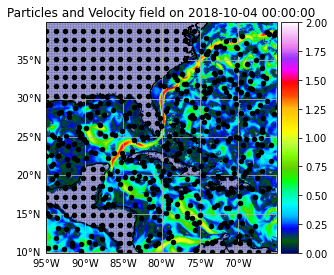

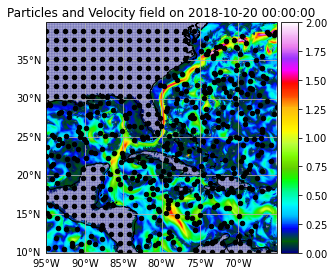

In [192]:
# save final particle positions and velocity field 
endtime = tt[-1]
rt = (endtime-tt[0]).astype(datetime)

pset.execute(AdvectionRK4, runtime=rt, dt=timedelta(minutes=5), 
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

pset.show(field='vector', show_time=tt[152], vmax=2.0, domain={'N':40, 'S':10, 'E':-65, 'W':-95}, land=True)
pset.show(field='vector', show_time=tt[256], vmax=2.0, domain={'N':40, 'S':10, 'E':-65, 'W':-95}, land=True)

In [ ]:
# save particle images for gif animation
slon = np.arange(-95,-65,1.2)
slat = np.arange(10,40,1.2)
lons, lats = np.meshgrid(slon,slat)
start_time = tt[0]
end_time = tt[-1]
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=start_time)

for cnt in range(60):
    # First plot the particles
    pset.show(savefile='hparticles'+str(cnt).zfill(2), field='vector', land=True, vmax=2.0, 
              domain={'N':32, 'S':10, 'E':-85, 'W':-55})
    # Then advect the particles
    pset.execute(AdvectionRK4,
                 runtime=timedelta(days=1),  # runtime controls the interval of the plots
                 dt=timedelta(minutes=5),
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})  # the recovery kernel

# then stich together saved images in ImageMagick

In [59]:
# animation zoomed in, focusing on hurricane hit florida
slon = np.arange(-90,-70,1)
slat = np.arange(18,35,1)
lons, lats = np.meshgrid(slon,slat)
start_time = tt[160]
end_time = tt[248]
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=start_time)

for cnt in range(100):
    # First plot the particles
    pset.show(savefile='cparticles'+str(cnt).zfill(2), field='vector', land=True, vmax=2.0, 
               domain={'N':35, 'S':18, 'E':-70, 'W':-90}, with_particles = True)
    # Then advect the particles
    pset.execute(AdvectionRK4,
                 runtime=timedelta(hours=3),  # runtime controls the interval of the plots
                 dt=timedelta(minutes=5),
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})  # the recovery kernel

# then stich together saved images in Gif Movie Gear

INFO: Plot saved to cparticles00.png
INFO: Compiled JITParticleAdvectionRK4 ==> C:\Users\alext\AppData\Local\Temp\parcels-tmp\9d55221dffd949ba7d52bf42975079b3_0.dll
INFO: Plot saved to cparticles01.png
INFO: Plot saved to cparticles02.png
INFO: Plot saved to cparticles03.png
INFO: Plot saved to cparticles04.png
INFO: Plot saved to cparticles05.png
INFO: Plot saved to cparticles06.png
INFO: Plot saved to cparticles07.png
INFO: Plot saved to cparticles08.png
INFO: Plot saved to cparticles09.png
INFO: Plot saved to cparticles10.png
INFO: Plot saved to cparticles11.png
INFO: Plot saved to cparticles12.png
INFO: Plot saved to cparticles13.png
INFO: Plot saved to cparticles14.png
INFO: Plot saved to cparticles15.png
INFO: Plot saved to cparticles16.png
INFO: Plot saved to cparticles17.png
INFO: Plot saved to cparticles18.png
INFO: Plot saved to cparticles19.png
INFO: Plot saved to cparticles20.png
INFO: Plot saved to cparticles21.png
INFO: Plot saved to cparticles22.png
INFO: Plot saved to c

INFO: Compiled JITParticleAdvectionRK4 ==> C:\Users\alext\AppData\Local\Temp\parcels-tmp\7f0a6a247a2c970b5a99f193390be9fe_0.dll


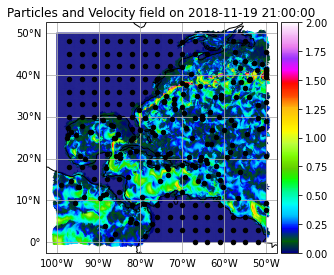

In [14]:
# show final particle location
rt = (tt[-1]-tt[0]).astype(datetime)

pset.execute(AdvectionRK4, runtime=rt, dt=timedelta(minutes=5), 
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
pset.show(field='vector', show_time=tt[-1], vmax=2.0, land=True)

In [313]:
# write particle trajectory into a .nc file
rt = (tt[-1]-tt[0]).astype(datetime)

output_file = pset.ParticleFile(name="Particle_hurricane", outputdt=timedelta(hours=1))
pset.execute(AdvectionRK4, runtime=rt, dt=timedelta(minutes=5), output_file=output_file, 
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

Exception ignored in: <bound method ParticleFile.__del__ of <parcels.particlefile.ParticleFile object at 0x00000205887F5550>>
Traceback (most recent call last):
  File "C:\Users\alext\miniconda3\envs\py3_parcels\lib\site-packages\parcels\particlefile.py", line 189, in __del__
    self.close()
  File "C:\Users\alext\miniconda3\envs\py3_parcels\lib\site-packages\parcels\particlefile.py", line 194, in close
    self.export()
  File "C:\Users\alext\miniconda3\envs\py3_parcels\lib\site-packages\parcels\particlefile.py", line 306, in export
    pset_info_local = np.load(os.path.join(tempwritedir, 'pset_info.npy'), allow_pickle=True).item()
  File "C:\Users\alext\miniconda3\envs\py3_parcels\lib\site-packages\numpy\lib\npyio.py", line 416, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: 'out-MJSGLIAV\\0\\pset_info.npy'
INFO: Compiled JITParticleAdvectionRK4 ==> C:\Users\alext\AppData\Local\Temp\parcels-tmp\8eed2e23e6a17

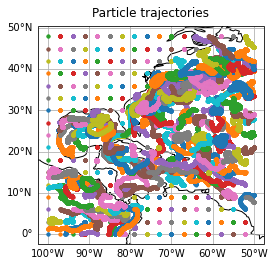

<module 'matplotlib.pyplot' from 'C:\\Users\\alext\\miniconda3\\envs\\py3_parcels\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [314]:
# want to close file and view results of path
output_file.export()
trag_file = 'Particle_hurricane.nc'
plotTrajectoriesFile(trag_file, mode='2d')

# can then use file to animate particles